<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/Hybrid_Model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install keras-layer-normalization
!pip install imageio

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import time

from IPython import display

from os.path import join
from os import listdir
from os.path import isfile, join, isdir

#import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, Conv3D, LayerNormalization, MaxPool3D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model

import matplotlib.pyplot as plt
import argparse
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow

TensorFlow 2.x selected.


In [0]:
class Config:
    def __init__(self, data_dir):
        self.DATASET_PATH = join(data_dir,"UCSDped1/Train")
        self.SINGLE_TEST_PATH = join(data_dir,"UCSDped1/Test/Test010")
        self.TEST_DIR = join(data_dir,"UCSDped1/Test/")
        self.BATCH_SIZE = 4
        self.EPOCHS = 3
        self.GEN_MODEL_PATH = join(data_dir,"model_gen_ep_4.hdf5")
        self.DIS_MODEL_PATH = join(data_dir,"model_dis_ep_4.hdf5")

conf = Config(data_dir="/content/drive/My Drive/UCSD_Anomaly_Dataset.v1p2/") 
physical_devices = tf.config.list_physical_devices('GPU') 
try: 
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
  # Invalid device or cannot modify virtual devices once initialized. 
  pass

In [0]:
def get_generator_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if reload_model:
        return load_model(conf.GEN_MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))

    return seq

def get_discriminator_model():
    ## input layer
    input_layer = tf.keras.Input(shape=(10, 256, 256, 1), batch_size=conf.BATCH_SIZE)

    ## convolutional layers
    conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', data_format="channels_last", padding="same")(input_layer)
    conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu', padding="same")(conv_layer1)

    ## add max pooling to obtain the most imformatic features
    pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

    conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding="same")(pooling_layer1)
    conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding="same")(conv_layer3)
    pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

    conv_layer5 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu', padding="same")(pooling_layer2)
    conv_layer6 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', padding="same")(conv_layer5)
    pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer6)
    ## perform batch normalization on the convolution outputs before feeding it to MLP architecture
    pooling_layer3 = BatchNormalization()(pooling_layer3)
    flatten_layer = Flatten()(pooling_layer3)

    ## create an MLP architecture with dense layers : 4096 -> 512 -> 128->1
    ## add dropouts to avoid overfitting / perform regularization
    dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    dense_layer3 = Dense(units=265, activation='relu')(dense_layer2)
    dense_layer3 = Dropout(0.4)(dense_layer3)
    output_layer = Dense(units=1, activation='softmax')(dense_layer3)
    ## define the model with input layer and output layer
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

def get_discriminator_model_v1(reload_model=True):
    
    if reload_model:
        return load_model(conf.DIS_MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    model = Sequential()
    ## convolutional layers
    model.add(Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', data_format="channels_last", padding="same", batch_input_shape=(None, 10, 256, 256, 1)))
    model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu', padding="same"))

    ## add max pooling to obtain the most imformatic features
    model.add(MaxPool3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding="same"))
    model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding="same"))
    model.add(MaxPool3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu', padding="same"))
    model.add(Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', padding="same"))
    model.add(MaxPool3D(pool_size=(2, 2, 2)))
    ## perform batch normalization on the convolution outputs before feeding it to MLP architecture
    model.add(BatchNormalization())
    model.add(Flatten())

    ## create an MLP architecture with dense layers : 4096 -> 512 -> 128->1
    ## add dropouts to avoid overfitting / perform regularization
    model.add(Dense(units=2048, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=1, activation='sigmoid'))
    
    return model



In [7]:
generator = get_generator_model()
print("Generator Summary===============================================>>")
generator.summary()
discriminator = get_discriminator_model_v1()
print("Discriminator Summary===============================================>>")
discriminator.summary()

Generator Summary===============================================>>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization (LayerNo (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_2 (Layer (None, 10, 32, 32, 64)    128       
_______________________________________________________

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)




In [0]:
generator_optimizer = tf.optimizers.Adam(1e-4, decay=1e-5, epsilon=1e-6)
discriminator_optimizer = tf.optimizers.Adam(1e-4, decay=1e-5, epsilon=1e-6)
#tf.keras.optimizers.Adam
#checkpoint_dir = './training_checkpoints'
#heckpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                discriminator_optimizer=discriminator_optimizer,
#                                 generator=generator,
#                                 discriminator=discriminator)


In [0]:
@tf.function
def train_step(images):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        real_output = discriminator(images, training=True)
        
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips

def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(conf.DATASET_PATH)):
        directory_path = join(conf.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))

                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips

def get_single_test(single_test_path):
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
            img = Image.open(join(single_test_path, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test


def get_all_tests():
    test_cases = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(conf.TEST_DIR)):
        directory_path = join(conf.TEST_DIR, f)
        if str(directory_path)[-3:] == "_gt":
            continue
        if isdir(directory_path):
            
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))

                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            test_cases.append(all_frames)
    
    return test_cases

def test_generator(test):
    
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = generator.predict(sequences,batch_size=4)
    for j in range(0, sz):
        clip_10 = reconstructed_sequences[j]
    #    img_prev = np.reshape(clip_10[0],(256,256))*256
        for k in range(1,2):
            img = np.reshape(clip_10[k],(256,256))*256
    #        optical_flow(img, img_prev)

    #        img_prev = img
            #print(img)
            #print("end of array\n")
            cv2_imshow(img)
            cv2.waitKey(0)
            break;
        break;
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()
    return reconstructed_sequences

def test_discriminator(reconstructed_sequences):
    sz = reconstructed_sequences.shape[0] - 10
    final_output = discriminator.predict(reconstructed_sequences,batch_size=4)

    plt.plot(final_output)
    plt.ylabel('Anomalous probability(t)')
    plt.xlabel('frame t')
    plt.show()


def test_with_all_cases():
    test_cases = get_all_tests()
    for test in test_cases:
        reconstructed_images = test_generator(test)
        test_discriminator(reconstructed_images)

def test_given_case(test_case_dir):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir))
    print(test.shape)
    cv2_imshow(test[10])
    cv2.waitKey(0)
    reconstructed_images = test_generator(test)
    test_discriminator(reconstructed_images)

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    for image_batch in dataset:
      train_step(image_batch)
    
    # Produce images for the GIF as we go
    display.clear_output(wait=True)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  generator.save(conf.GEN_MODEL_PATH,save_format='h5')
  discriminator.save(conf.DIS_MODEL_PATH,save_format='h5')
  # Generate after the final epoch
  display.clear_output(wait=True)



In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(get_training_set())).batch(conf.BATCH_SIZE)



In [0]:
for data in train_dataset:
    print(data)
    break

(200, 256, 256, 1)


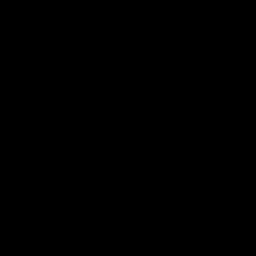

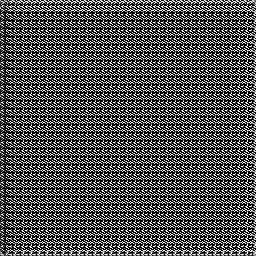

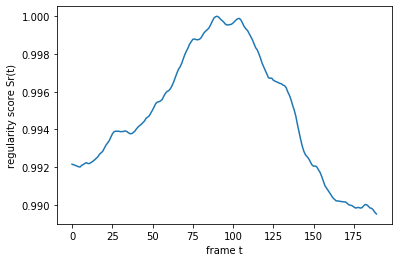

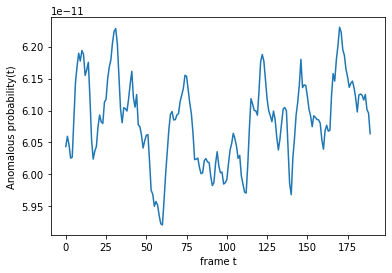

(200, 256, 256, 1)


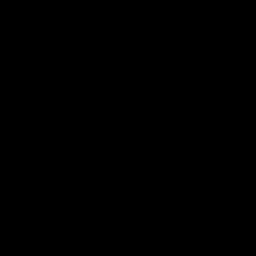

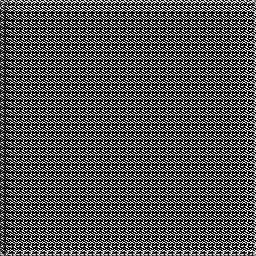

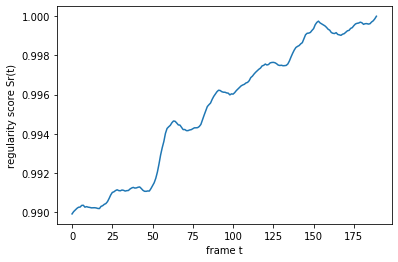

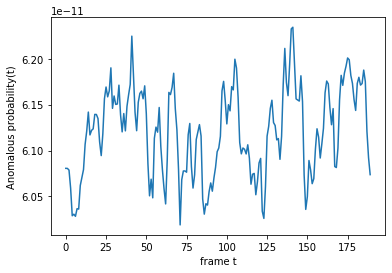

In [33]:
#train_dataset = tf.data.Dataset.from_tensor_slices(np.array(get_training_set())).batch(conf.BATCH_SIZE)
#train(train_dataset, conf.EPOCHS)
#reconstructed_images = test_generator()
#test_discriminator(reconstructed_images)

test_given_case("Test001")
test_given_case("Test002")